# **Analisis dan Prediksi Dini resiko kematian pada Penyakit Gagal Jantung**

22.11.5018 Dwi Ferdiyanto <br>
22.11.5035 Nadhif Fauzil Adhim <br>
22.11.5060 Rif'aa Surososastro S

# Import Library PYspark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, NaiveBayes, DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import col, sum as _sum
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import numpy as np

# Inisialisasi Pyspark session

In [ ]:
spark = SparkSession.builder.appName("HeartFailureClassification").getOrCreate()

# Memuat Datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = spark.read.csv('/content/drive/MyDrive/Big Data & Data Mining/Datasets/heart_failure_clinical_records.csv', header=True, inferSchema=True)
data.show()
data.printSchema()

+------+-------+------------------------+--------+-----------------+-------------------+---------+----------------+------------+---+-------+----+-----------+
|   age|anaemia|creatinine_phosphokinase|diabetes|ejection_fraction|high_blood_pressure|platelets|serum_creatinine|serum_sodium|sex|smoking|time|DEATH_EVENT|
+------+-------+------------------------+--------+-----------------+-------------------+---------+----------------+------------+---+-------+----+-----------+
|  55.0|      0|                     748|       0|               45|                  0|263358.03|             1.3|         137|  1|      1|  88|          0|
|  65.0|      0|                      56|       0|               25|                  0| 305000.0|             5.0|         130|  1|      0| 207|          0|
|  45.0|      0|                     582|       1|               38|                  0| 319000.0|             0.9|         140|  0|      0| 244|          0|
|  60.0|      1|                     754|       1|  

Dataset ini terdiri dari 5000 entri dengan 13 kolom yang berisi informasi tentang pasien, termasuk faktor-faktor medis, gaya hidup, dan hasil kematian terkait penyakit kardiovaskular. Dataset ini dapat digunakan untuk analisis atau prediksi hasil kesehatan pasien (variabel target: DEATH_EVENT).
Distribusi Variabel Target (DEATH_EVENT):

0 (Tidak meninggal): 68.64%
1 (Meninggal): 31.36%

# **PREPROCESSING**

# Rename kolom agar jelas dan mudah dibaca

 menggunakan PySpark untuk mengganti nama kolom-kolom dalam sebuah DataFrame bernama data. Tujuannya adalah untuk menstandarisasi nama kolom agar lebih konsisten, mudah dibaca, dan kompatibel dengan fungsi atau library lain

In [ ]:
data = data.withColumnRenamed('age', 'Age') \
           .withColumnRenamed('anaemia', 'Anaemia') \
           .withColumnRenamed('creatinine_phosphokinase', 'Creatinine_Phosphokinase') \
           .withColumnRenamed('diabetes', 'Diabetes') \
           .withColumnRenamed('ejection_fraction', 'Ejection_Fraction') \
           .withColumnRenamed('high_blood_pressure', 'High_Blood_Pressure') \
           .withColumnRenamed('platelets', 'Platelets') \
           .withColumnRenamed('serum_creatinine', 'Serum_Creatinine') \
           .withColumnRenamed('serum_sodium', 'Serum_Sodium') \
           .withColumnRenamed('sex', 'Sex') \
           .withColumnRenamed('smoking', 'Smoking') \
           .withColumnRenamed('time', 'Time') \
           .withColumnRenamed('DEATH_EVENT', 'label')

In [ ]:
data.printSchema()
data.show(5)

root
 |-- Age: double (nullable = true)
 |-- Anaemia: integer (nullable = true)
 |-- Creatinine_Phosphokinase: integer (nullable = true)
 |-- Diabetes: integer (nullable = true)
 |-- Ejection_Fraction: integer (nullable = true)
 |-- High_Blood_Pressure: integer (nullable = true)
 |-- Platelets: double (nullable = true)
 |-- Serum_Creatinine: double (nullable = true)
 |-- Serum_Sodium: integer (nullable = true)
 |-- Sex: integer (nullable = true)
 |-- Smoking: integer (nullable = true)
 |-- Time: integer (nullable = true)
 |-- label: integer (nullable = true)

+----+-------+------------------------+--------+-----------------+-------------------+---------+----------------+------------+---+-------+----+-----+
| Age|Anaemia|Creatinine_Phosphokinase|Diabetes|Ejection_Fraction|High_Blood_Pressure|Platelets|Serum_Creatinine|Serum_Sodium|Sex|Smoking|Time|label|
+----+-------+------------------------+--------+-----------------+-------------------+---------+----------------+------------+---+----

# Cek Nilai Kosong

Tidak ada data kosong dalam datesets ini, sehingga pemrosesan data kosong tidak dilakukan

In [ ]:
missing_count = data.select([_sum(col(c).isNull().cast('int')).alias(c) for c in data.columns])
missing_count.show()

+---+-------+------------------------+--------+-----------------+-------------------+---------+----------------+------------+---+-------+----+-----+
|Age|Anaemia|Creatinine_Phosphokinase|Diabetes|Ejection_Fraction|High_Blood_Pressure|Platelets|Serum_Creatinine|Serum_Sodium|Sex|Smoking|Time|label|
+---+-------+------------------------+--------+-----------------+-------------------+---------+----------------+------------+---+-------+----+-----+
|  0|      0|                       0|       0|                0|                  0|        0|               0|           0|  0|      0|   0|    0|
+---+-------+------------------------+--------+-----------------+-------------------+---------+----------------+------------+---+-------+----+-----+



# **EDA ( Exporatory Data Analysis )**

Dataset Spark diubah ke Pandas DataFrame untuk analisis lokal. Matriks korelasi menunjukkan hubungan antara fitur dengan heatmap.

In [ ]:
pandas_df = data.toPandas()

# Corelation Matrix

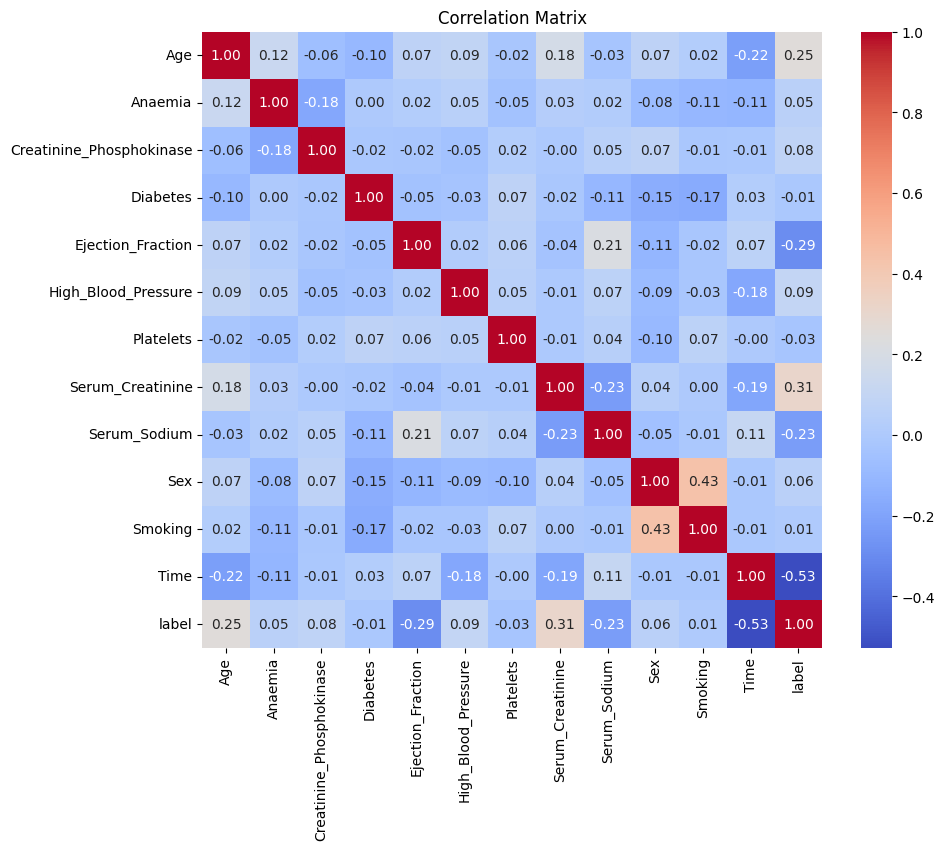

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(pandas_df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


Nilai korelasi dilihat dari angka pada kolom DEATH_EVENT, di mana:

Positif: Semakin tinggi nilai fitur, semakin tinggi kemungkinan terjadinya DEATH_EVENT. <br>
Negatif: Semakin rendah nilai fitur, semakin tinggi kemungkinan DEATH_EVENT.
Korelasi yang signifikan adalah sebagai berikut:

* time: Korelasi negatif tertinggi dengan nilai -0.53. Artinya, semakin lama waktu pengamatan pasien, semakin kecil kemungkinan DEATH_EVENT terjadi.
* ejection_fraction: Korelasi negatif -0.29. Semakin tinggi nilai fraksi ejeksi jantung, semakin kecil kemungkinan DEATH_EVENT.
* serum_creatinine: Korelasi positif 0.31. Artinya, semakin tinggi nilai kreatinin serum (indikasi fungsi ginjal menurun), semakin tinggi kemungkinan DEATH_EVENT terjadi.
* age: Korelasi positif 0.25. Usia yang lebih tua cenderung meningkatkan risiko DEATH_EVENT.
* high_blood_pressure dan creatinine_phosphokinase memiliki korelasi positif yang kecil, 0.09 dan 0.08, sehingga dampaknya terhadap DEATH_EVENT kecil.

# Bar chart untuk distribusi fitur Kategorikal

<ipython-input-28-685010087c20>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=pandas_df, x=feature, palette='viridis', hue=None)
<ipython-input-28-685010087c20>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=pandas_df, x=feature, palette='viridis', hue=None)
<ipython-input-28-685010087c20>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=pandas_df, x=feature, palette='viridis', hue=None)
<ipython-input-28-685010087c20>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in

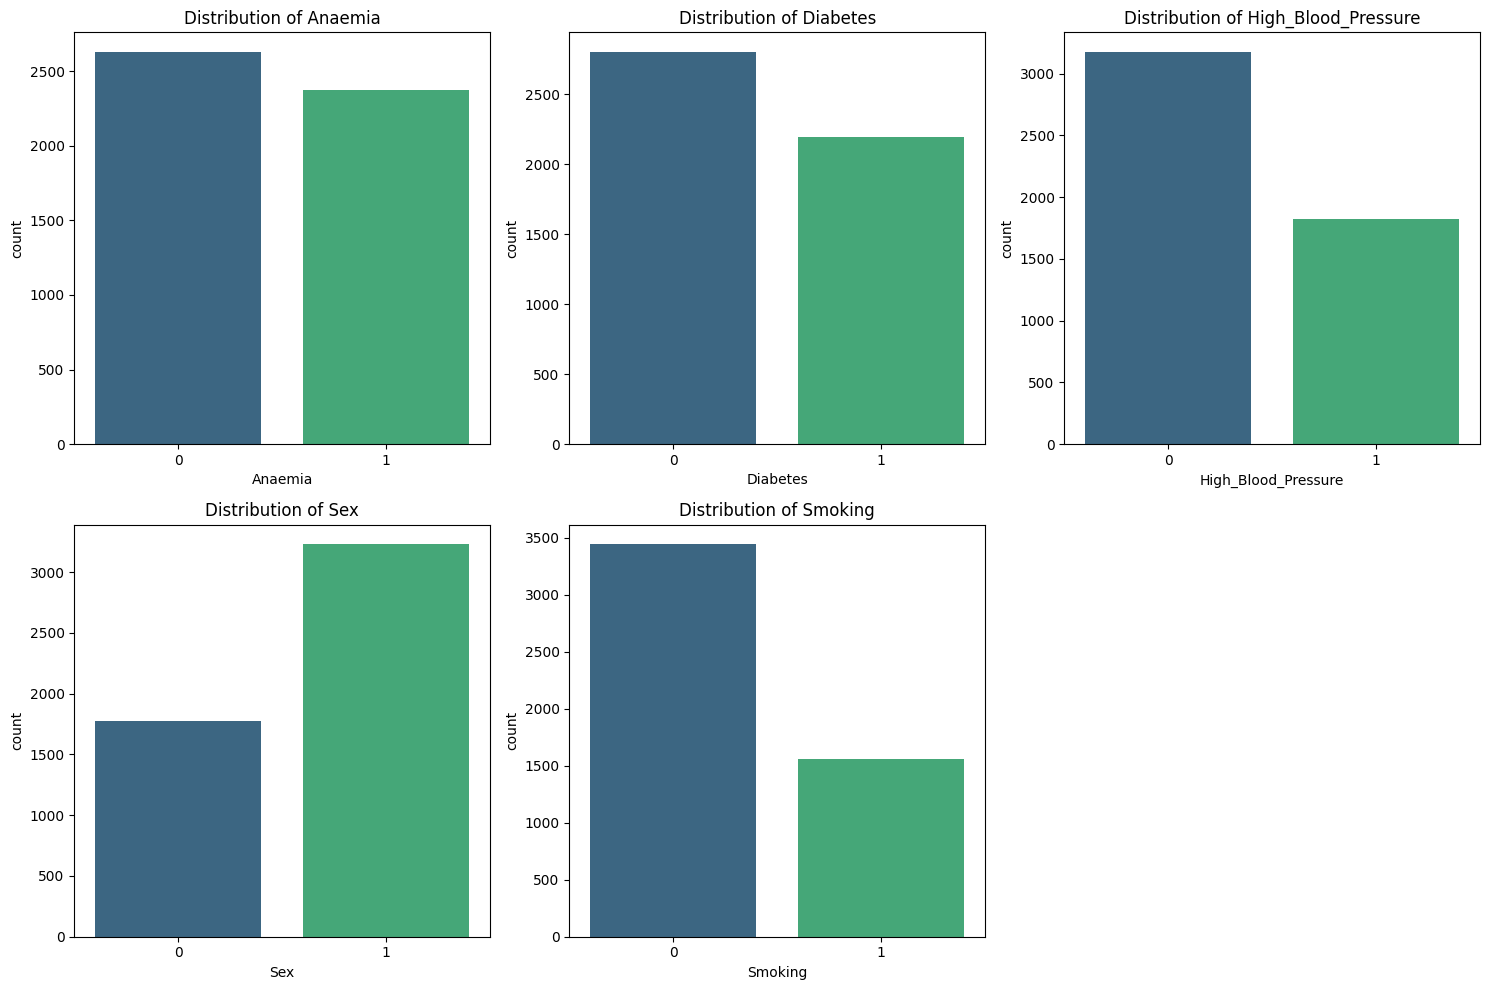

In [ ]:
categorical_features = ['Anaemia', 'Diabetes', 'High_Blood_Pressure', 'Sex', 'Smoking']
plt.figure(figsize=(15, 10))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(2, 3, i)
    sns.countplot(data=pandas_df, x=feature, palette='viridis', hue=None)
    plt.title(f"Distribution of {feature}")
plt.tight_layout()
plt.show()

# Distribusi Data Pada target

* Death Event (0): Sebanyak 68.6% dari total pasien tidak mengalami kematian akibat gagal jantung.
* Death Event (1): Sebanyak 31.4% dari total pasien mengalami kematian akibat gagal jantung.
Distribusi ini menunjukkan ketidakseimbangan data (imbalanced data), di mana jumlah pasien yang tidak mengalami kematian jauh lebih besar dibandingkan pasien yang mengalami kematian

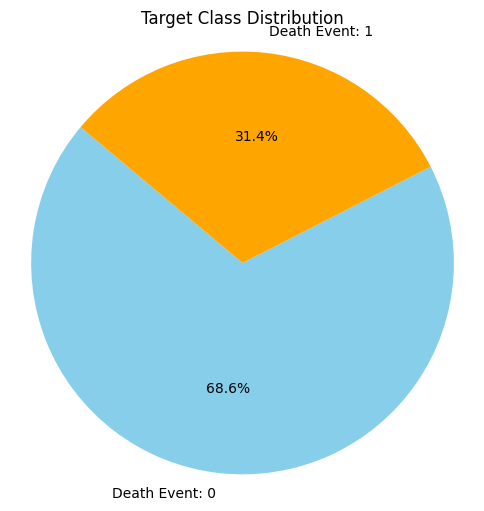

In [ ]:
labels = pandas_df['label'].value_counts().index
sizes = pandas_df['label'].value_counts().values
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=[f'Death Event: {int(label)}' for label in labels], autopct='%1.1f%%', colors=['skyblue', 'orange'], startangle=140)
plt.title('Target Class Distribution')
plt.axis('equal')
plt.show()

# Histogram for numerical feature distribution

Menunjukan distribusi data pada tiap fitur

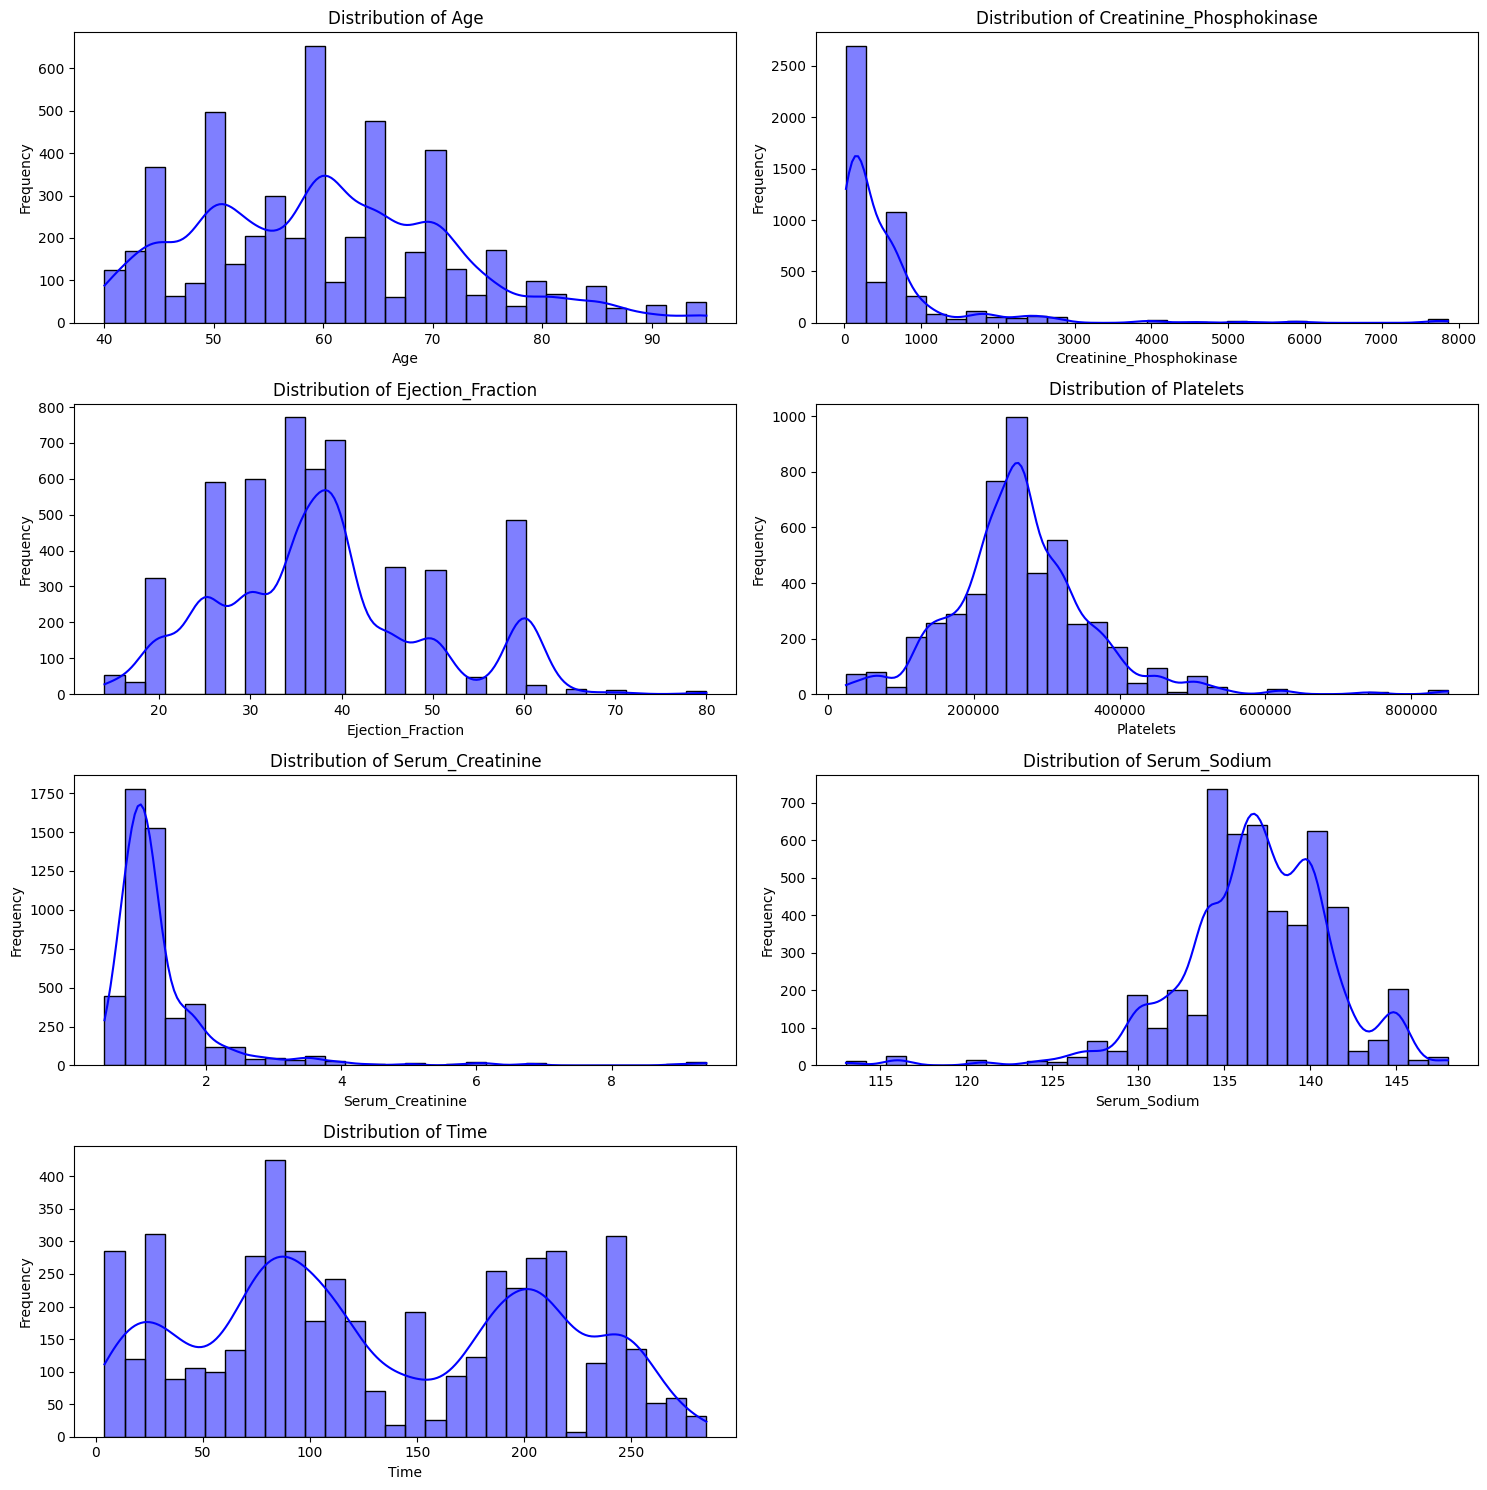

In [ ]:
numerical_features = ['Age', 'Creatinine_Phosphokinase', 'Ejection_Fraction', 'Platelets', 'Serum_Creatinine', 'Serum_Sodium', 'Time']
plt.figure(figsize=(15, 15))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(4, 2, i)
    sns.histplot(pandas_df[feature], kde=True, bins=30, color='blue')
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

#  Boxplot untuk tiap fitur dengan Target

Membandingkan distribusi setiap fitur berdasarkan kelas target (label).

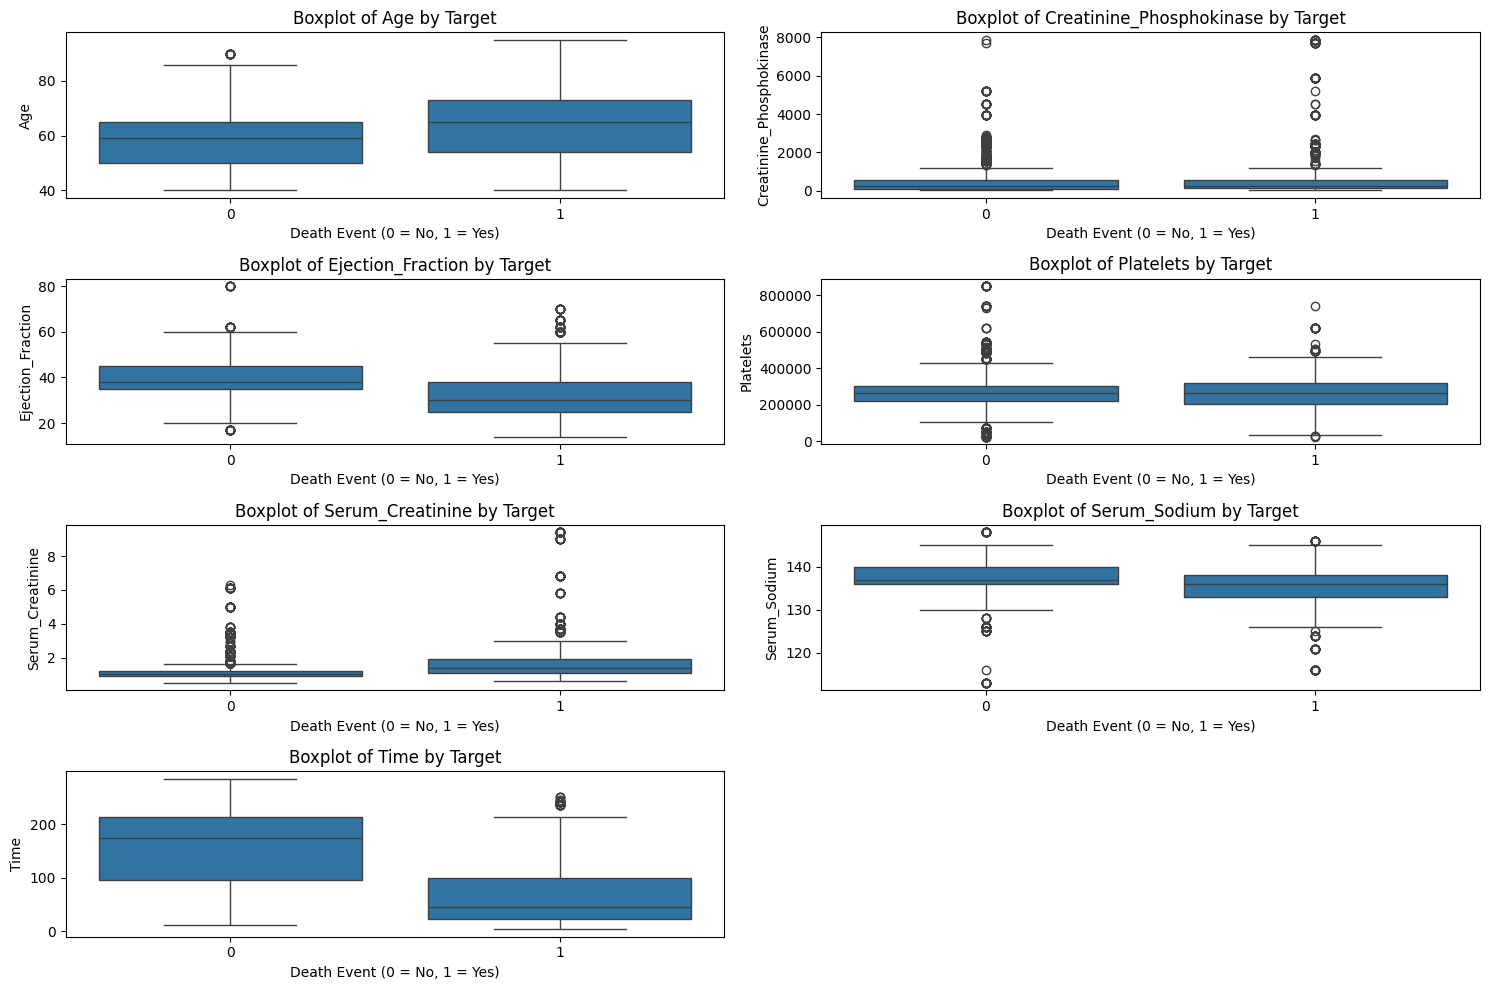

In [ ]:
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(4, 2, i)
    sns.boxplot(x='label', y=feature, data=pandas_df)
    plt.title(f"Boxplot of {feature} by Target")
    plt.xlabel('Death Event (0 = No, 1 = Yes)')
    plt.ylabel(feature)
plt.tight_layout()
plt.show()

#Menyusun Fitur

# **Alasan Pemilihan Fitur**
Berdasarkan analisis korelasi, fitur-fitur yang dipilih adalah:

* Ejection Fraction: Fitur ini memiliki korelasi negatif kuat dengan label (-0.29), yang menunjukkan bahwa nilai-nilainya dapat berpengaruh signifikan terhadap prediksi.

* Serum Creatinine: Korelasi sebesar 0.31 menunjukkan hubungan positif yang cukup kuat dengan label, sehingga fitur ini dianggap relevan.

* Time: Korelasi negatif yang cukup kuat (-0.53) menunjukkan bahwa fitur ini sangat berpengaruh dalam menentukan prediksi.

* Age: Korelasi positif dengan nilai 0.25 menunjukkan bahwa fitur ini memiliki pengaruh sedang terhadap prediksi, dan oleh karena itu disertakan sebagai salah satu fitur penting.

* Serum Sodium : Korelasi Negatif dengan nilai -0.23 menunjukan hubungan negatif sedang dengan label, sehingga fitur ini dianggap relevan

Pemilihan fitur-fitur ini dilakukan untuk menjaga keseimbangan antara kompleksitas model dan relevansi fitur terhadap target (label), sehingga dapat meningkatkan performa model dengan fokus pada variabel yang memiliki hubungan signifikan terhadap hasil prediksi.



In [ ]:
feature_columns = ['Ejection_Fraction', 'Serum_Creatinine', 'Time', 'Age','Serum_Sodium']
# feature_columns = [col for col in data.columns if col != 'label']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(data)

# Normalisasi Fitur

Menstandarisasi data untuk memastikan semua fitur berada pada skala yang sama, penting untuk algoritma berbasis jarak.

In [ ]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
data = scaler.fit(data).transform(data)

# Membagi Dataset

Membagi data menjadi dua subset: data latih (80%) dan data uji (20%).

In [ ]:
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Inisalisasi Model

In [ ]:
rf_model = RandomForestClassifier(featuresCol="scaledFeatures", labelCol="label")
gbt_model = GBTClassifier(featuresCol="scaledFeatures", labelCol="label")
nb_model = NaiveBayes(featuresCol="scaledFeatures", labelCol="label")
dt_model = DecisionTreeClassifier(featuresCol="scaledFeatures", labelCol="label")

models = {
    'Random Forest': rf_model,
    'Gradient Boosted Trees': gbt_model,
    'Naive Bayes': nb_model,
    'Decision Tree': dt_model
}

# Evaluasi Model

In [ ]:
results = {}
evaluator_auc = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")

def evaluate_model(model, train_data, test_data):
    model_fitted = model.fit(train_data)
    predictions = model_fitted.transform(test_data)
    auc = evaluator_auc.evaluate(predictions)
    accuracy = evaluator_accuracy.evaluate(predictions)
    return auc, accuracy

for name, model in models.items():
    auc, accuracy = evaluate_model(model, train_data, test_data)
    results[name] = {'AUC': auc, 'Accuracy': accuracy}
    print(f"\n{name} Results:")
    print(f"AUC: {auc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")


Random Forest Results:
AUC: 0.9756
Accuracy: 0.9134

Gradient Boosted Trees Results:
AUC: 0.9923
Accuracy: 0.9854

Naive Bayes Results:
AUC: 0.6709
Accuracy: 0.7662

Decision Tree Results:
AUC: 0.8436
Accuracy: 0.9102


# Hyperparameter tuning for Gradient Boosted Trees

In [ ]:
paramGrid = ParamGridBuilder() \
    .addGrid(GBTClassifier.maxDepth, [5, 10]) \
    .addGrid(GBTClassifier.maxIter, [50, 100]) \
    .addGrid(GBTClassifier.stepSize, [0.05, 0.1]) \
    .build()
crossval = CrossValidator(estimator=gbt_model,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator_auc,
                          numFolds=3)

gbt_cv_model = crossval.fit(train_data)
best_gbt_model = gbt_cv_model.bestModel

## Evaluasi Parameter terbaik Gradient Boosted Trees model:

In [ ]:
gbt_predictions = best_gbt_model.transform(test_data)
gbt_auc = evaluator_auc.evaluate(gbt_predictions)
gbt_accuracy = evaluator_accuracy.evaluate(gbt_predictions)

In [ ]:
print("\nBest Gradient Boosted Trees Model Results:")
print(f"AUC: {gbt_auc:.4f}")
print(f"Accuracy: {gbt_accuracy:.4f}")


Best Gradient Boosted Trees Model Results:
AUC: 0.9923
Accuracy: 0.9854


In [ ]:
print("Parameter Gradient Boosted Trees Terbaik")
print(f"Maksimal Kedalaman (Max Depth) : {best_gbt_model._java_obj.getMaxDepth()}")
print(f"Maksimal Iterasi (Max Iterations) : {best_gbt_model._java_obj.getMaxIter()}")
print(f"Step Size: {best_gbt_model._java_obj.getStepSize()}")


Parameter Gradient Boosted Trees Terbaik
Maksimal Kedalaman (Max Depth) : 5
Maksimal Iterasi (Max Iterations) : 20
Step Size: 0.1


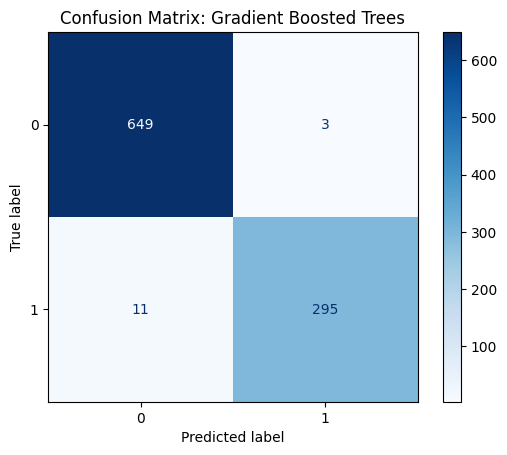

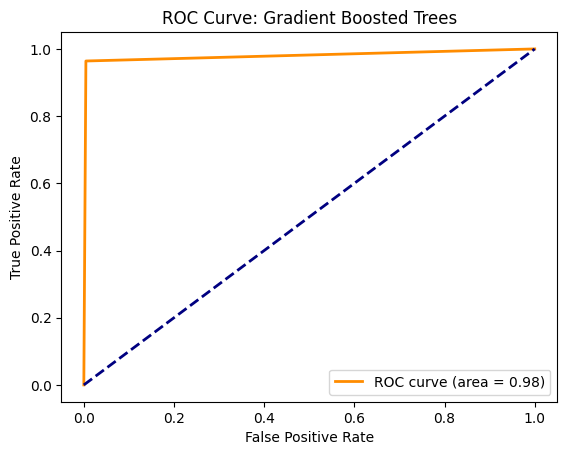

In [ ]:
# Confusion Matrix
gbt_predictions_pd = gbt_predictions.select("label", "prediction").toPandas()
conf_matrix_gbt = confusion_matrix(gbt_predictions_pd['label'], gbt_predictions_pd['prediction'])
ConfusionMatrixDisplay(conf_matrix_gbt, display_labels=[0, 1]).plot(cmap='Blues')
plt.title('Confusion Matrix: Gradient Boosted Trees')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(gbt_predictions_pd['label'], gbt_predictions_pd['prediction'])
roc_auc_value = sklearn.metrics.auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_value:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Gradient Boosted Trees')
plt.legend(loc="lower right")
plt.show()

# Hyperparameter tuning untuk Random Forest

In [ ]:
paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf_model.numTrees, [10, 50, 100]) \
    .addGrid(rf_model.maxDepth, [5, 10, 15]) \
    .addGrid(rf_model.featureSubsetStrategy, ['auto', 'sqrt', 'log2']) \
    .build()
crossval_rf = CrossValidator(estimator=rf_model,
                             estimatorParamMaps=paramGrid_rf,
                             evaluator=evaluator_auc,
                             numFolds=3)

rf_cv_model = crossval_rf.fit(train_data)
best_rf_model = rf_cv_model.bestModel

## Evaluasi Parameter terbaik Random Forest model

In [ ]:
rf_predictions = best_rf_model.transform(test_data)
rf_auc = evaluator_auc.evaluate(rf_predictions)
rf_accuracy = evaluator_accuracy.evaluate(rf_predictions)

print("\nBest Random Forest Model Results:")
print(f"AUC: {rf_auc:.4f}")
print(f"Accuracy: {rf_accuracy:.4f}")


Best Random Forest Model Results:
AUC: 0.9998
Accuracy: 0.9948


In [ ]:
print("Parameter Random Forest Terbaik")
print(f"Jumlah Pohon: {best_rf_model.getNumTrees}")
print(f"Max Depth: {best_rf_model._java_obj.getMaxDepth()}")
print(f"Feature Subset : {best_rf_model._java_obj.getFeatureSubsetStrategy()}")


Parameter Random Forest Terbaik
Jumlah Pohon: 50
Max Depth: 10
Feature Subset : auto


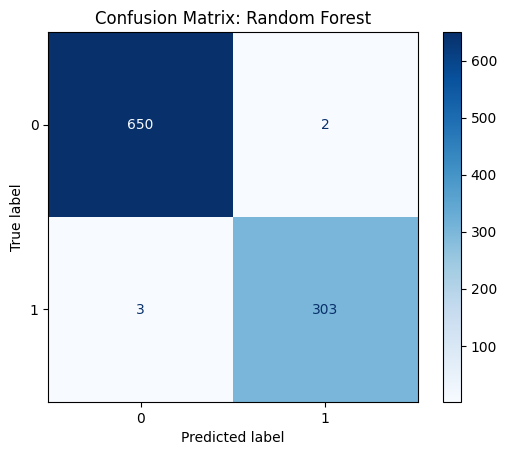

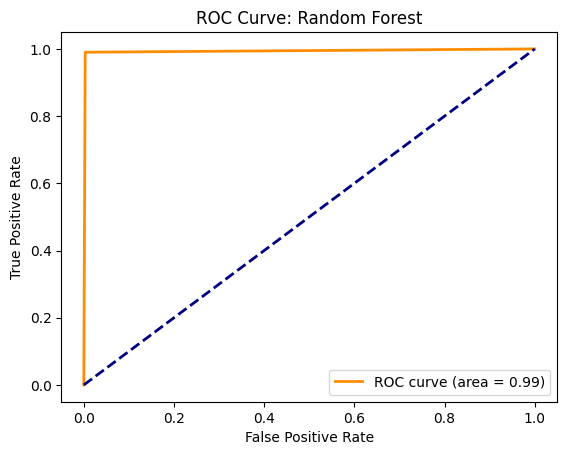

In [ ]:
# Confusion Matrix
rf_predictions_pd = rf_predictions.select("label", "prediction").toPandas()
conf_matrix_rf = confusion_matrix(rf_predictions_pd['label'], rf_predictions_pd['prediction'])
ConfusionMatrixDisplay(conf_matrix_rf, display_labels=[0, 1]).plot(cmap='Blues')
plt.title('Confusion Matrix: Random Forest')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(rf_predictions_pd['label'], rf_predictions_pd['prediction'])
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Random Forest')
plt.legend(loc="lower right")
plt.show()

# Stop Spark session

In [ ]:
spark.stop()